# Elife Paper 
## Figure 5
### Reward Landscapes

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import json 
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap

In [10]:
# load parameters from json file
params_path = "params_4_jumps.json" # yeah we are using the old one again, its good shit
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 40
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING)                  
print(f'Random seed is {RANDOM_SEED}')

1
Random seed is 40


In [3]:
# Config
# 1 to load model
# 1 to save model
load = 0
save = 0
model_version = "model_4_40"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


100%|██████████| 60/60 [00:29<00:00,  2.01it/s]


### A

In [4]:
def plot_traj_with_RA(syll, smoothen_traj = False, N_i = None, N_f = None, steepness = 5.0):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    x_motor = np.array(x_motor)
    y_motor = np.array(y_motor)

    # RA contribution trajectory
    ra_actions = obj.actions - obj.actions_bg   
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig)

    # Axes layout
    ax_main = fig.add_subplot(gs[:, :])    # Main trajectory plot
    # ax_xhist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # X histogram
    # ax_yhist = fig.add_subplot(gs[1:, 3], sharey=ax_main)   # Y histogram
    # ax_cbar = fig.add_subplot(gs[0, 3])  # Colorbar axis

    cmap = color_contour_bckg  # Match the colormap style from plot_landscape
    levels_ = 50

    if obj.LANDSCAPE == 0:
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = ax_main.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        if if_contour:
            ax_main.contour(X, Y, Z, levels=15, colors='k', linewidths=1, alpha=0.9)
        ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
    else:
        Z = obj.syrinx_contours[syll]
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 256), np.linspace(-limit, limit, 256)
        X, Y = np.meshgrid(x, y)
        target_pos = obj.syrinx_targets[syll]
        cs = ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
        if if_contour:
            ax_main.contour(Y, X, Z, levels=20, colors='k', linewidths=0.2, alpha=0.3)
        ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')
        ax_main.set_xticks([-1, 0, 1], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1, 0, 1], [-1, 0, 1], fontsize=15)

    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    # ax_main.scatter(x_traj[0], y_traj[0],
    #             s=200, c='yellow', edgecolors='black',
    #             marker='o', linewidths=2, zorder=3, label='Starting Point')

    # ax_main.scatter(x_traj[-1], y_traj[-1],
    #             s=200, c='red', edgecolors='black',
    #             marker='o', linewidths=2, zorder=4, label='Ending Point')
    day_i = 0
    day_f = DAYS
    ax_main.scatter(x_traj[day_i * TRIALS: day_f * TRIALS][0], y_traj[day_i * TRIALS: day_f * TRIALS][0],
                s=150, c='black',
                marker='s', zorder=5, label='Starting Point')
    ax_main.scatter(x_traj[day_i * TRIALS: day_f * TRIALS][-1], y_traj[day_i * TRIALS: day_f * TRIALS][-1],
                s=150, c='white',
                marker='X', zorder=5, label='Ending Point')
    ax_main.scatter(x_traj[day_i * TRIALS: day_f * TRIALS][0], y_traj[day_i * TRIALS: day_f * TRIALS][0],
                s=50, c='white',
                marker='s', zorder=6, label='Starting Point')
    ax_main.scatter(x_traj[day_i * TRIALS: day_f * TRIALS][-1], y_traj[day_i * TRIALS: day_f * TRIALS][-1],
                s=50, c='black',
                marker='x', zorder=6, label='Ending Point')
    
    if smoothen_traj:
        xtraj_smooth = running_mean_dynamic(np.array(x_traj), N_i=N_i, N_f=N_f, steepness=steepness)
        ytraj_smooth = running_mean_dynamic(np.array(y_traj), N_i=N_i, N_f=N_f, steepness=steepness)
        ax_main.plot(
            xtraj_smooth[0 * TRIALS: DAYS * TRIALS],
            ytraj_smooth[0 * TRIALS: DAYS * TRIALS],
            color = color_motor, label='Agent Trajectory', alpha=0.8, linewidth=1, marker='.', markersize=1
        )

    else:
        ax_main.plot(
            x_traj[0 * TRIALS: DAYS * TRIALS][::N_f],
            y_traj[0 * TRIALS: DAYS * TRIALS][::N_f],
            color = color_motor, label='Agent Trajectory', alpha=1, linewidth=0.0, marker='.', markersize=1
        )
    ax_main.plot(
        x_ra[0 * TRIALS: DAYS * TRIALS][::10],
        y_ra[0 * TRIALS: DAYS * TRIALS][::10],
        color=color_cortical, label='RA Contribution', alpha=0.5, linewidth=0.0, marker='.', markersize=1
    )
    ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
    # ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
    # ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)

    # Grouped motor trajectory
    group_size = 10
    num_groups = DAYS // group_size
    colors = cm.get_cmap('bwr', num_groups)

    num_bins = 50
    x_bin_edges = np.linspace(x_motor.min(), x_motor.max(), num_bins + 1)
    y_bin_edges = np.linspace(y_motor.min(), y_motor.max(), num_bins + 1)

    # for group in range(num_groups):
    #     start_day = group * group_size
    #     end_day = (group + 1) * group_size
    #     start_idx = start_day * TRIALS
    #     end_idx = end_day * TRIALS

    #     ax_xhist.hist(x_motor[start_idx:end_idx], bins=x_bin_edges, alpha=0.5, color=colors(group), edgecolor='black')
    #     ax_yhist.hist(y_motor[start_idx:end_idx], bins=y_bin_edges, orientation='horizontal', alpha=0.5, color=colors(group), edgecolor='black')
    #     ax_main.scatter(x_motor[start_idx:end_idx:5], y_motor[start_idx:end_idx:5], color=colors(group), s=1, alpha=0.5)

    # # Plot RA contribution
    # # ax_main.plot(x_ra[::100], y_ra[::100], color='maroon', lw=2, label='RA contribution')

    # # ax_main.legend()

    # # Styling histograms
    # ax_xhist.set_yticks([])
    # ax_xhist.spines['top'].set_visible(False)
    # ax_xhist.spines['right'].set_visible(False)
    # ax_xhist.spines['left'].set_visible(False)

    # ax_yhist.set_xticks([])
    # ax_yhist.spines['top'].set_visible(False)
    # ax_yhist.spines['right'].set_visible(False)
    # ax_yhist.spines['bottom'].set_visible(False)

    # plt.setp(ax_xhist.get_xticklabels(), visible=False)
    # plt.setp(ax_yhist.get_yticklabels(), visible=False)
    # ax_xhist.set_ylabel("Freq (X)")
    # ax_yhist.set_xlabel("Freq (Y)")

    # Colorbar for groups
    norm = Normalize(vmin=0, vmax=num_groups * group_size)
    sm = ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])

    # # cbar = plt.colorbar(sm, cax=ax_cbar, orientation='vertical')
    # cbar.set_label('Day', rotation=270, labelpad=15, fontsize=15)
    # cbar.set_ticks([group_size * i*2 for i in range(num_groups//2+1)])
    # cbar.ax.tick_params(labelsize=15)
    # cbar.set_ticklabels([f"{group_size * i}" for i in range(num_groups + 1)])

    plt.tight_layout()
    plt.show()


### C

In [5]:
def plot_output(obj, syll):
    figure, (ax1, ax2) = plt.subplots(2,1)
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_DAILY_MOTIFS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    x_bg_traj, y_bg_traj = zip(*obj.actions_bg[:, :, syll, :].reshape(-1, 2))
    ra_actions = obj.actions - obj.actions_bg
    x_ra_traj, y_ra_traj = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_bg_traj = np.array(x_bg_traj)
    y_bg_traj = np.array(y_bg_traj)
    x_ra_traj = np.array(x_ra_traj)
    y_ra_traj = np.array(y_ra_traj)


    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    # for syll in range(N_SYLL):
        # motor outputs
    ax1.plot(running_mean(obj.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_motor, lw=1, alpha=.9)
    ax2.plot(running_mean(obj.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_motor, lw=1, alpha=.9)

    ## RA contribution
    ax1.plot(running_mean(x_ra_traj.reshape(DAYS*N_DAILY_MOTIFS), 1), color=color_cortical, lw=1, alpha=.9, label='RA contribution')
    ax2.plot(running_mean(y_ra_traj.reshape(DAYS*N_DAILY_MOTIFS), 1), color=color_cortical, lw=1, alpha=.9)
    # #     # BG contribution
    ax1.plot(running_mean(x_bg_traj.reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_bg, lw=1, alpha=.9, label='BG contribution')
    ax2.plot(running_mean(y_bg_traj.reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_bg, lw=1, alpha=.9)
    # for syll in range(N_SYLL - 1):
    #     # target
    #     ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    #     ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    # if N_SYLL > 1:
    #     ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    #     ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
    # elif N_SYLL == 1:
    ax1.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
    ax2.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)

    # Axis beauty
    # ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1] )
    ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*(DAYS))
    
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1]   )
    ax2.set_ylim(-LIMIT, LIMIT)
    ax2.tick_params(labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*(DAYS+1), 20*N_DAILY_MOTIFS), np.arange(40, DAYS+1+40, 20))
    plt.tight_layout()
    plt.show()


### D.1

In [6]:

def plot_traj_panels(syll):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))

    # RA contribution trajectory
    ra_actions = obj.actions - obj.actions_bg
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    # Settings
    group_size = 12
    num_groups = DAYS // group_size
    rows = 1
    cols = num_groups

    # Create full figure with two parts: 1 row for main panel, rest for subplots
    full_fig = plt.figure(figsize=(6 * cols,  5 * rows))  # dynamic height
    full_gs = GridSpec(nrows=rows, ncols=cols, figure=full_fig, height_ratios= [1] * rows, hspace=0.6)
    # print(f"Rows: {rows}, Cols: {cols}")
    # ==== Main Panel (first row, spanning all columns) ====
    # ax_main = full_fig.add_subplot(full_gs[0, :])

    cmap = color_contour_bckg #LinearSegmentedColormap.from_list('white_to_black', ['white', 'purple'])


    # ==== Subplots for group trajectories ====
    for group in range(num_groups):
        r = (group // cols)   # +1 because row 0 is for main panel
        c = group % cols
        outer_spec = GridSpecFromSubplotSpec(2, 2,
                                             width_ratios=[4, 1], height_ratios=[1, 4],
                                             subplot_spec=full_gs[r, c], wspace=0.05, hspace=0.05)

        ax_main = full_fig.add_subplot(outer_spec[1, 0])
        ax_xhist = full_fig.add_subplot(outer_spec[0, 0], sharex=ax_main)
        ax_yhist = full_fig.add_subplot(outer_spec[1, 1], sharey=ax_main)

        start_idx = group * group_size * TRIALS
        end_idx = (group + 1) * group_size * TRIALS
        traj_x = x_motor[start_idx:end_idx]
        traj_y = y_motor[start_idx:end_idx]
        ra_x = x_ra[start_idx:end_idx]
        ra_y = y_ra[start_idx:end_idx]

        ax_main.plot(traj_x, traj_y, color=color_motor, alpha=0.1, lw= 0, marker='.', markersize=1)
        # ax_main.scatter(traj_x[0], traj_y[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2, zorder=3)
        # ax_main.scatter(traj_x[-1], traj_y[-1], s=100, c='yellow', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2, zorder=3)


        # ax_main.plot(ra_x, ra_y, color='maroon', alpha=0.1, lw= 0, marker='.', markersize=1)
        ax_main.set_xlim([-1.5, 1.5])
        ax_main.set_ylim([-1.5, 1.5])
        ax_main.set_xticks([])
        ax_main.set_yticks([])
        ax_main.set_aspect('equal')
        # ax_main.set_title(f"Days {group * group_size}-{(group + 1) * group_size}", fontsize=8, loc='left', pad=5)

        ax_xhist.hist(traj_x, bins=20, color=color_motor)
        ax_yhist.hist(traj_y, bins=20, color=color_motor, orientation='horizontal')
        ax_xhist.axis('off')
        ax_yhist.axis('off')

        if obj.LANDSCAPE == 0:
            limit = obj.limit
            x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
            X, Y = np.meshgrid(x, y)
            Z = obj.get_reward([X, Y], syll)
            ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
            if if_contour:
                ax_main.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.3)
        else:
            Z = obj.syrinx_contours[syll]
            target_pos = obj.syrinx_targets[syll]
            ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
            if if_contour:
                ax_main.contour(Z.T, levels=10, colors='k', linewidths=1, alpha=0.3)
            ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

        # Learning trajectory markers
        # ax_main.plot(x_motor, y_motor, color='C1', alpha=0.2, lw= 0, marker='.', markersize=0.5)    
        # ax_main.scatter(x_motor[0], y_motor[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[BG_INTACT_DAYS * TRIALS - 1], y_motor[BG_INTACT_DAYS * TRIALS - 1], s=100, c='orange', marker='X', label='End Before Lesion', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[-1], y_motor[-1], s=100, c='crimson', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2)
        if group == 0:
            ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        # ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
        ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        # ax_main.set_title("Full Motor Trajectory", fontsize=18)
        # ax_main.legend()
    plt.text(0.1, 0.45, f"Motor trajectory", ha='center', va='center',
        fontsize=25, transform=full_fig.transFigure, rotation=90)

    # full_fig.suptitle("Full Motor Trajectory and Grouped Segments", fontsize=22)
    # plt.tight_layout()
    plt.show()


### D.2

In [7]:

def plot_RA_traj_panels(syll):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))

    # RA contribution trajectory
    ra_actions = obj.actions - obj.actions_bg
    x_ra, y_ra = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    # Settings
    group_size = 12
    num_groups = DAYS // group_size
    rows = 1
    cols = num_groups

    # Create full figure with two parts: 1 row for main panel, rest for subplots
    full_fig = plt.figure(figsize=(6 * cols,  5 * rows))  # dynamic height
    full_gs = GridSpec(nrows=rows, ncols=cols, figure=full_fig, height_ratios= [1] * rows, hspace=0.6)
    # print(f"Rows: {rows}, Cols: {cols}")
    # ==== Main Panel (first row, spanning all columns) ====
    # ax_main = full_fig.add_subplot(full_gs[0, :])

    cmap = color_contour_bckg #LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])


    # ==== Subplots for group trajectories ====
    for group in range(num_groups):
        r = (group // cols)   # +1 because row 0 is for main panel
        c = group % cols
        outer_spec = GridSpecFromSubplotSpec(2, 2,
                                             width_ratios=[4, 1], height_ratios=[1, 4],
                                             subplot_spec=full_gs[r, c], wspace=0.05, hspace=0.05)

        ax_main = full_fig.add_subplot(outer_spec[1, 0])
        ax_xhist = full_fig.add_subplot(outer_spec[0, 0], sharex=ax_main)
        ax_yhist = full_fig.add_subplot(outer_spec[1, 1], sharey=ax_main)

        start_idx = group * group_size * TRIALS
        end_idx = (group + 1) * group_size * TRIALS
        traj_x = x_motor[start_idx:end_idx]
        traj_y = y_motor[start_idx:end_idx]
        ra_x = x_ra[start_idx:end_idx]
        ra_y = y_ra[start_idx:end_idx]

        # ax_main.plot(traj_x, traj_y, color='black', alpha=0.1, lw= 0, marker='.', markersize=1) 
        ax_main.plot(ra_x, ra_y, color = color_cortical, alpha=0.1, lw= 0, marker='.', markersize=1)
        ax_main.set_xlim([-1.5, 1.5])
        ax_main.set_ylim([-1.5, 1.5])
        ax_main.set_xticks([])
        ax_main.set_yticks([])
        ax_main.set_aspect('equal')
        # ax_main.set_title(f"Days {group * group_size}-{(group + 1) * group_size}", fontsize=8, loc='left', pad=5)

        ax_xhist.hist(ra_x, bins=20, color = color_cortical)
        ax_yhist.hist(ra_y, bins=20, color = color_cortical, orientation='horizontal')
        ax_xhist.axis('off')
        ax_yhist.axis('off')

        if obj.LANDSCAPE == 0:
            limit = obj.limit
            x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
            X, Y = np.meshgrid(x, y)
            Z = obj.get_reward([X, Y], syll)
            ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
            if if_contour:
                ax_main.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.3)
        else:
            Z = obj.syrinx_contours[syll]
            target_pos = obj.syrinx_targets[syll]
            ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
            if if_contour:
                ax_main.contour(Z.T, levels=10, colors='k', linewidths=1, alpha=0.3)
            ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

        # Learning trajectory markers
        # ax_main.plot(x_motor, y_motor, color='C1', alpha=0.2, lw= 0, marker='.', markersize=0.5)    
        # ax_main.scatter(x_motor[0], y_motor[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[BG_INTACT_DAYS * TRIALS - 1], y_motor[BG_INTACT_DAYS * TRIALS - 1], s=100, c='orange', marker='X', label='End Before Lesion', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[-1], y_motor[-1], s=100, c='crimson', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2)
        if group == 0:
            ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        # ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
        ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        # ax_main.set_title("Full Motor Trajectory", fontsize=18)
        # ax_main.legend()

    plt.text(0.1, 0.45, f"HVC Contribution", ha='center', va='center',
         fontsize=25, transform=full_fig.transFigure, rotation=90)
    # full_fig.suptitle("Full Motor Trajectory and Grouped Segments", fontsize=22)
    # plt.tight_layout()
    plt.show()


### D.3

In [8]:

def plot_BG_contri_panels(syll):
    # Motor trajectory
    x_motor, y_motor = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))

    # BG contribution trajectory
    bg_actions = obj.actions_bg
    x_ra, y_ra = zip(*bg_actions[:, :, syll, :].reshape(-1, 2))
    x_ra = np.array(x_ra)
    y_ra = np.array(y_ra)

    # Settings
    group_size = 12
    num_groups = DAYS // group_size
    rows = 1
    cols = num_groups

    # Create full figure with two parts: 1 row for main panel, rest for subplots
    full_fig = plt.figure(figsize=(6 * cols,  5 * rows))  # dynamic height
    full_gs = GridSpec(nrows=rows, ncols=cols, figure=full_fig, height_ratios= [1] * rows, hspace=0.6)
    # print(f"Rows: {rows}, Cols: {cols}")
    # ==== Main Panel (first row, spanning all columns) ====
    # ax_main = full_fig.add_subplot(full_gs[0, :])

    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])


    # ==== Subplots for group trajectories ====
    for group in range(num_groups):
        r = (group // cols)   # +1 because row 0 is for main panel
        c = group % cols
        outer_spec = GridSpecFromSubplotSpec(2, 2,
                                             width_ratios=[4, 1], height_ratios=[1, 4],
                                             subplot_spec=full_gs[r, c], wspace=0.05, hspace=0.05)

        ax_main = full_fig.add_subplot(outer_spec[1, 0])
        ax_xhist = full_fig.add_subplot(outer_spec[0, 0], sharex=ax_main)
        ax_yhist = full_fig.add_subplot(outer_spec[1, 1], sharey=ax_main)

        start_idx = group * group_size * TRIALS
        end_idx = (group + 1) * group_size * TRIALS
        traj_x = x_motor[start_idx:end_idx]
        traj_y = y_motor[start_idx:end_idx]
        bg_x = x_ra[start_idx:end_idx]
        bg_y = y_ra[start_idx:end_idx]

        # ax_main.plot(traj_x, traj_y, color='black', alpha=0.1, lw= 0, marker='.', markersize=1) 
        ax_main.plot(bg_x, bg_y, color=color_bg, alpha=0.1, lw= 0, marker='.', markersize=1)
        ax_main.set_xlim([-1.5, 1.5])
        ax_main.set_ylim([-1.5, 1.5])
        ax_main.set_xticks([])
        ax_main.set_yticks([])
        ax_main.set_aspect('equal')
        ax_main.set_xlabel(f"Days {40 + group * group_size}-{40 + (group + 1) * group_size}", fontsize=20)

        ax_xhist.hist(bg_x, bins=20, color=color_bg)
        ax_yhist.hist(bg_y, bins=20, color=color_bg, orientation='horizontal')
        ax_xhist.axis('off')
        ax_yhist.axis('off')

        if obj.LANDSCAPE == 0:
            limit = obj.limit
            x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
            X, Y = np.meshgrid(x, y)
            Z = obj.get_reward([X, Y], syll)
            # ax_main.contourf(X, Y, Z, levels=20, cmap=cmap)
            # ax_main.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.3)
        else:
            Z = obj.syrinx_contours[syll]
            target_pos = obj.syrinx_targets[syll]
            ax_main.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1])
            if if_contour:
                ax_main.contour(Z.T, levels=10, colors='k', linewidths=1, alpha=0.3)
            ax_main.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

        # Learning trajectory markers
        # ax_main.plot(x_motor, y_motor, color='C1', alpha=0.2, lw= 0, marker='.', markersize=0.5)    
        # ax_main.scatter(x_motor[0], y_motor[0], s=100, c='blue', marker='X', label='Start of Learning', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[BG_INTACT_DAYS * TRIALS - 1], y_motor[BG_INTACT_DAYS * TRIALS - 1], s=100, c='orange', marker='X', label='End Before Lesion', edgecolor='black', linewidth=1.2)
        # ax_main.scatter(x_motor[-1], y_motor[-1], s=100, c='crimson', marker='X', label='After Lesion', edgecolor='black', linewidth=1.2)
        if group == 0:
            ax_main.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        # ax_main.set_xlabel(r'$P_{\beta}$', fontsize=20)
        ax_main.set_xticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        ax_main.set_yticks([-1.5, 0, 1.5], [-1, 0, 1], fontsize=15)
        # ax_main.set_title("Full Motor Trajectory", fontsize=18)
        # ax_main.legend()

    plt.text(0.1, 0.45, f"BG contribution", ha='center', va='center',
         fontsize=25, transform=full_fig.transFigure, rotation=90)
    # full_fig.suptitle("Full Motor Trajectory and Grouped Segments", fontsize=22)
    # plt.tight_layout()
    plt.show()




### A, C, D: MC, RA, BG trajectories

C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_27632\2596370248.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('bwr', num_groups)


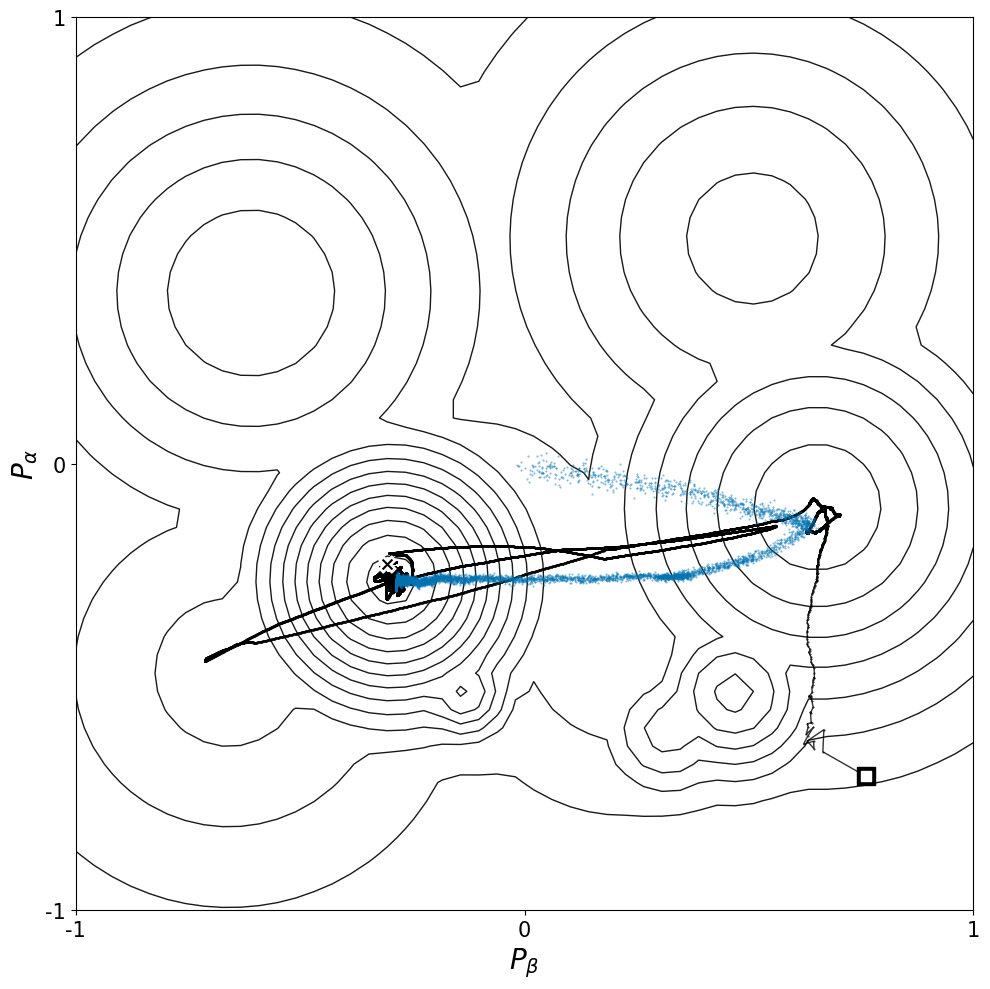

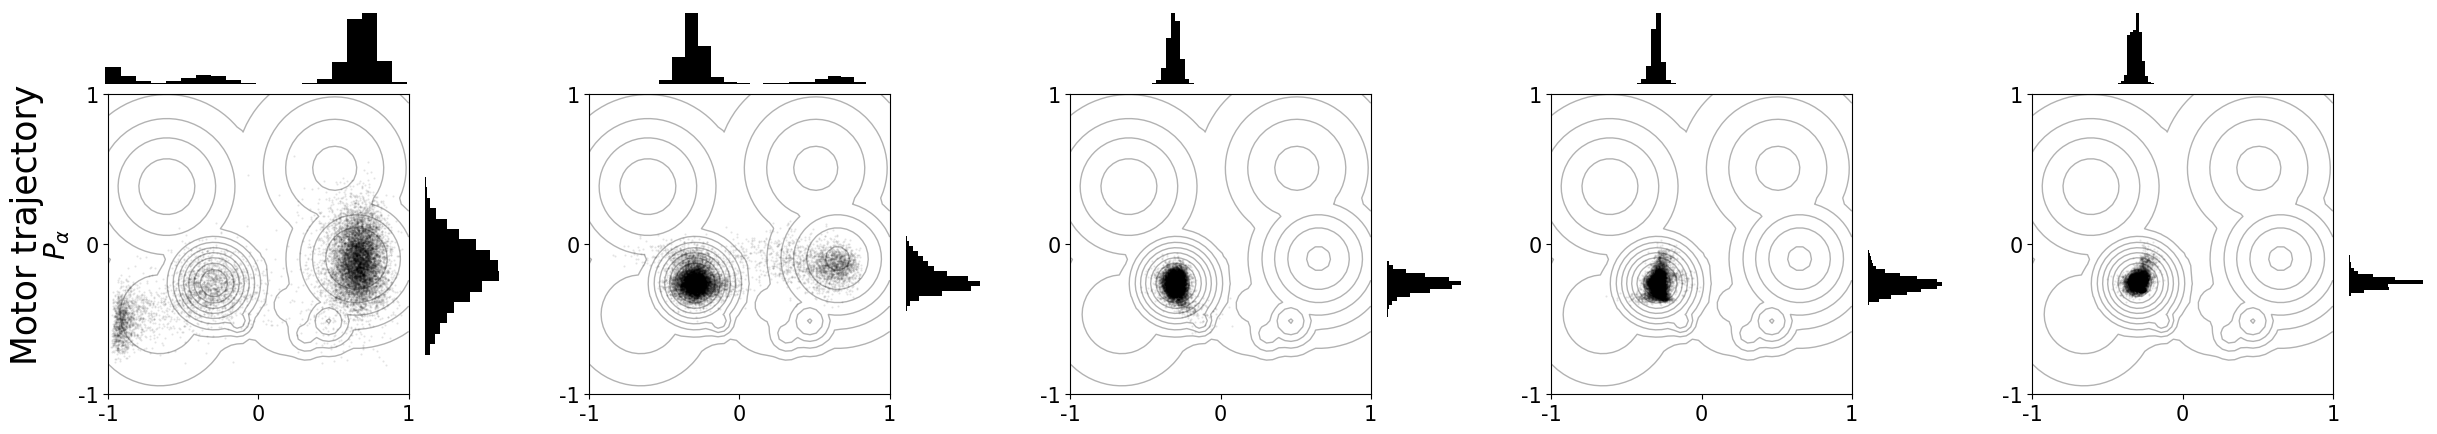

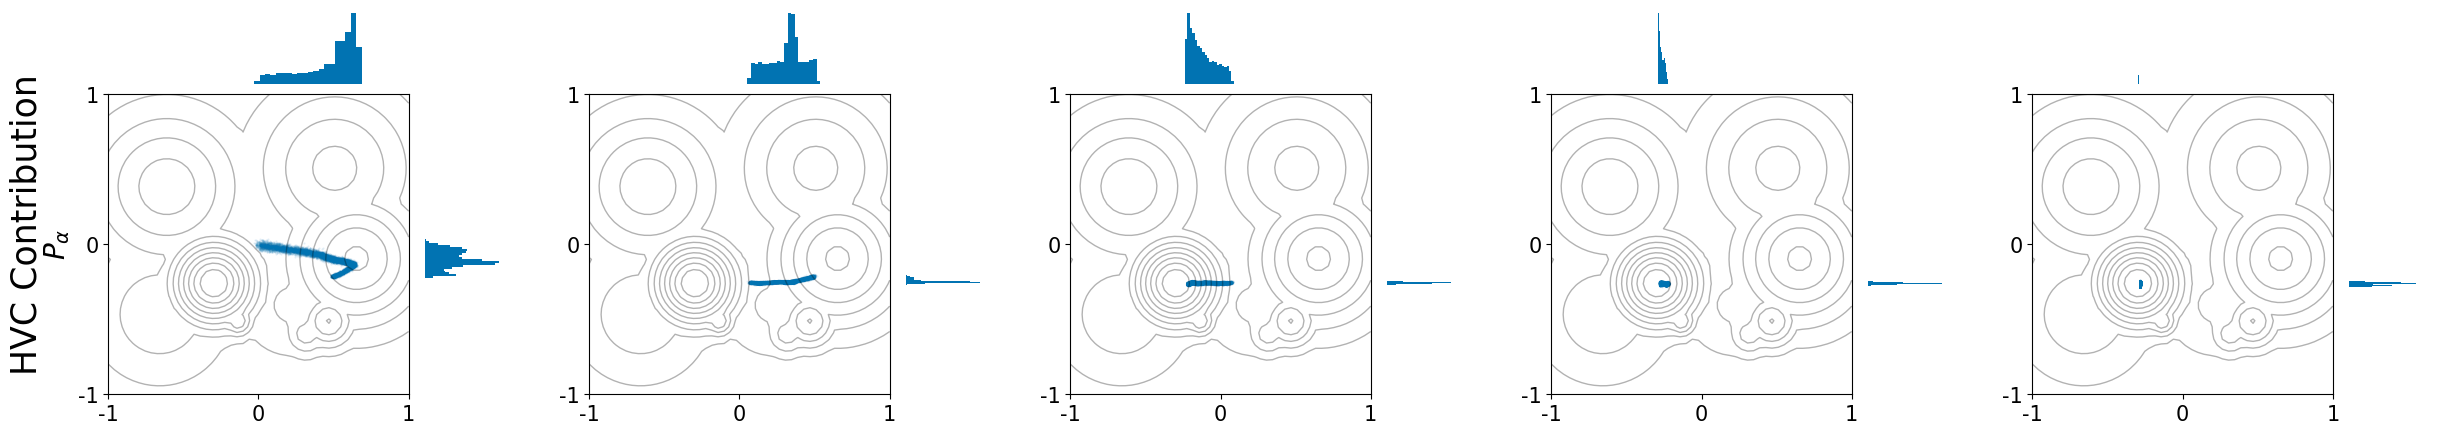

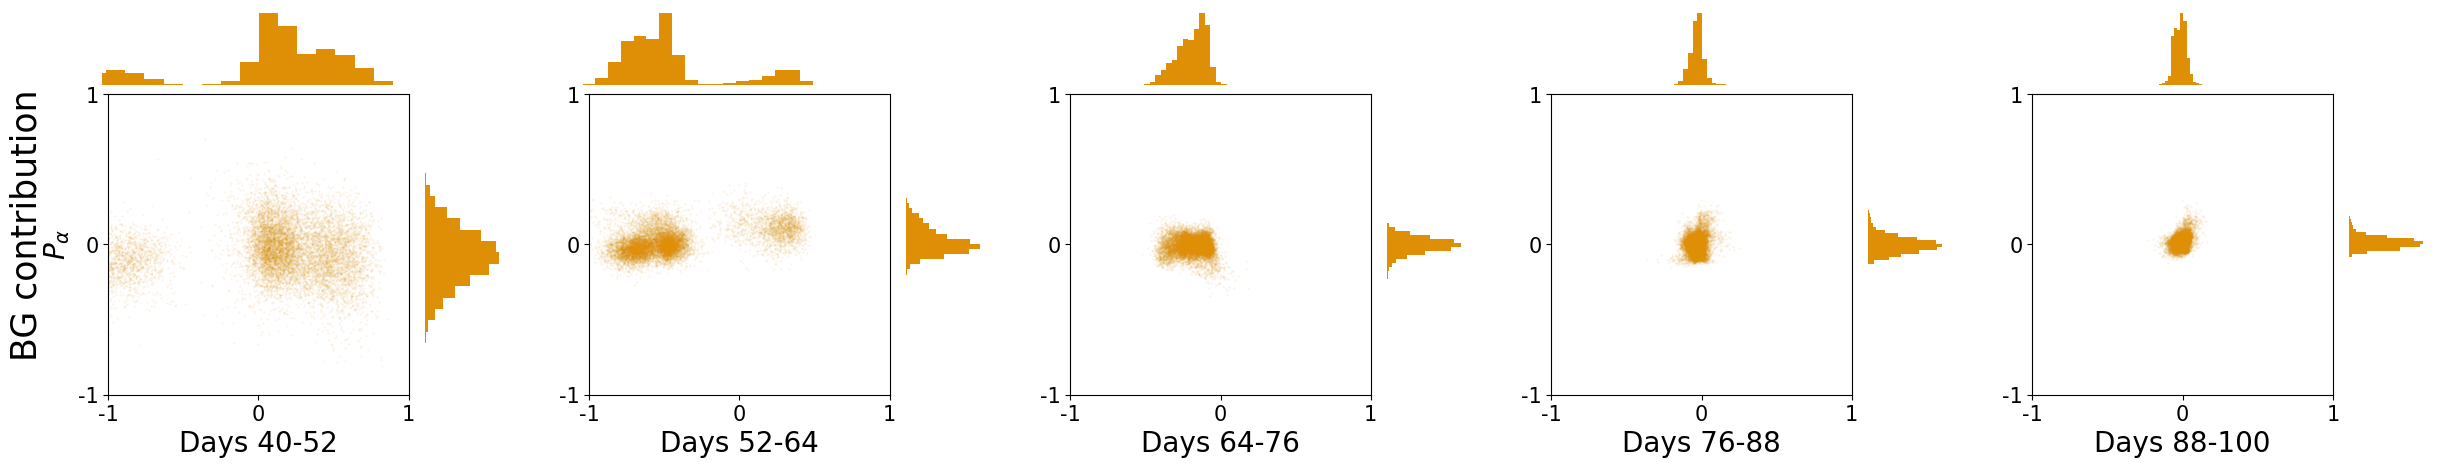

C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_27632\3093896854.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))


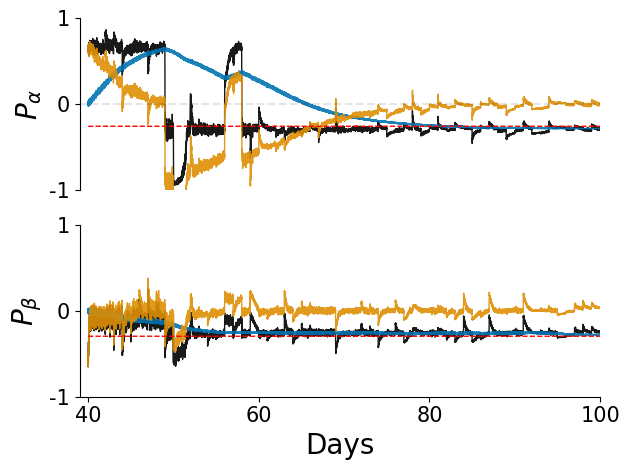

In [9]:
plot_traj_with_RA(syll = 2, smoothen_traj = True, N_i = 1, N_f = 2000, steepness = 100)
plot_traj_panels(2)
plot_RA_traj_panels(2)
plot_BG_contri_panels(2)
plot_output(obj, 2)


### E: Variability 

In [7]:
# def plot_motor_variability(obj):
#     fig, ax = plt.subplots(1, 1, figsize=(14,2))

#     days = np.arange(DAYS)
#     all_syll_std_x = []
#     all_syll_std_y = []
#     all_std = []

#     for syll in [2]:
#         stds_x = []
#         stds_y = []
#         for day in days:
#             traj_x = obj.actions[day, :, syll, 0]
#             traj_y = obj.actions[day, :, syll, 1]
#             stds_x.append(np.std(traj_x))
#             stds_y.append(np.std(traj_y))

#             ax.plot([min(60, max(0, day+np.random.normal())), min(60, max(0, day+np.random.normal()))], [np.std(traj_x), np.std(traj_y)], color='black', alpha=0.9, lw=0, marker='.', markersize=1)       
#         # ax.plot(days, np.array(stds_x), color='black', alpha=0.9, lw=0, marker='.', markersize=1)
#         # ax.plot(days, np.array(stds_y), color='black', alpha=0.9, lw=0, marker='.', markersize=1)
#         # all_syll_std_x.append(running_mean(stds_x, 2))
#         # all_syll_std_y.append(running_mean(stds_y, 2))
#         all_std.append(running_mean((np.array(stds_x) + np.array(stds_y))/2.0, 2))

#     all_syll_std_x = np.array(all_syll_std_x)
#     all_syll_std_y = np.array(all_syll_std_y)
#     all_std = np.array(all_std)

#     mean_x = np.mean(all_syll_std_x, axis=0)
#     std_x = np.std(all_syll_std_x, axis=0)
#     mean_y = np.mean(all_syll_std_y, axis=0)
#     std_y = np.std(all_syll_std_y, axis=0)

#     # Use visually distinct and colorblind-friendly colors
#     color_x = 'black'  # Teal green
#     color_y = 'black'
#     ax.plot(days, running_mean(np.mean(all_std, axis=0), 2), color=color_motor, label='Overall Variability')
    
#     # ax.plot(days, mean_x, color=color_x, label=r'$P_{\alpha}$')
#     # # ax.fill_between(days, mean_x - std_x, mean_x + std_x, color=color_x, alpha=0.1)

#     # ax.plot(days, mean_y, color=color_y, label=r'$P_{\beta}$')
#     # # ax.fill_between(days, mean_y - std_y, mean_y + std_y, color=color_y, alpha=0.1)

#     # Plot settings
#     ax.set_ylabel("Motor Variability", fontsize=12)
#     ax.set_xlabel("Days", fontsize=12)
#     ax.set_xticks(range(0, DAYS+1, 20), np.arange(40, DAYS+1 + 40, 20), fontsize=15)

#     ax.legend(frameon=False, loc='upper right')
#     ax.tick_params(labelsize=12)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_yticks([])
#     ax.set_xlim(-1, DAYS)
#     ax.set_ylim(0, 0.3)
#     plt.tight_layout()
#     plt.show()

def plot_motor_variability(obj):
    fig, ax = plt.subplots(1, 1, figsize=(14,2))

    days = np.arange(DAYS)

    stds_x = []
    stds_y = []
    mean_std = []
    
    # Collect std per day for x and y
    for day in days:
        traj_x = obj.actions[day, :, 2, 0]   # syllable 2
        traj_y = obj.actions[day, :, 2, 1]
        sx = np.std(traj_x)
        sy = np.std(traj_y)
        stds_x.append(sx)
        stds_y.append(sy)
        mean_std.append((sx + sy) / 2.0)

    stds_x = np.array(stds_x)
    stds_y = np.array(stds_y)
    mean_std = np.array(mean_std)

    # Smooth running mean if desired
    mean_std_smoothed = running_mean(mean_std, 2)
    stds_x_smoothed = running_mean(stds_x, 2)
    stds_y_smoothed = running_mean(stds_y, 2)

    # Compute shaded region from x and y std
    upper = np.maximum(stds_x_smoothed, stds_y_smoothed)
    lower = np.minimum(stds_x_smoothed, stds_y_smoothed)

    # Plot thick mean line (mean of x and y)
    ax.plot(days, mean_std_smoothed, color=color_motor, lw=2, label='Mean (x,y) STD')

    # Fill between min and max of x,y std as a “band”
    ax.fill_between(days, lower, upper, color=color_motor, alpha=0.2)

    # Optional: scatter x,y individually (if you want to see dots)
    # ax.scatter(days, stds_x, color='black', s=2, alpha=0.5)
    # ax.scatter(days, stds_y, color='grey', s=2, alpha=0.5)

    # Plot settings
    ax.set_ylabel("Motor Variability", fontsize=12)
    ax.set_xlabel("Days", fontsize=12)
    ax.set_xticks(range(0, DAYS+1, 20), np.arange(40, DAYS+1 + 40, 20), fontsize=15)

    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(-1, DAYS)
    ax.set_ylim(0, 0.3)
    plt.tight_layout()
    plt.show()


# def plot_bg_variability(obj):
#     fig, ax = plt.subplots(1, 1, figsize=(14, 2))
#     days = np.arange(DAYS)
#     syll = 2
#     stds = []
#     for day in days:
#         bg_overtime = obj.bg_all[day, :, syll, :]
#         stds.append(np.std(bg_overtime, axis=0).mean())

#     stds_running = running_std(stds, window=2)
#     ax.plot(stds_running, label=f"Syllable {syll}", color=color_bg)
#     # Plot settings
#     ax.set_ylabel("BG Variability", fontsize=12)
#     ax.set_xlabel("Days", fontsize=12)

#     # Lesion marker
#     # ax.axvline(BG_INTACT_DAYS-1, linestyle=':', color='grey', lw=1, label='Lesion')
#     # ax.set_xticks(range(0, DAYS * N_DAILY_MOTIFS, 20*N_DAILY_MOTIFS), np.arange(40, DAYS+40, 20), fontsize=15)
#     # ax.vlines(x = np.arange(0, DAYS * N_DAILY_MOTIFS, N_DAILY_MOTIFS), ymin=0, ymax=0.5, color='grey', alpha=0.2, lw=0.5)
#     # Legends and aesthetics
#     # ax.legend(frameon=False, fontsize=13, loc='upper left', bbox_to_anchor=(0.65, 1.0))  # shifted right
#     ax.tick_params(labelsize=12)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_yticks([])

#     plt.tight_layout()
#     plt.show()

def plot_bg_variability(obj):
    fig, ax = plt.subplots(1, 1, figsize=(14, 2))
    days = np.arange(DAYS)
    syll = 2  # choose syllable index

    # shape: (days, neurons)
    # for each day, for each neuron we compute std across time
    stds_per_neuron = []
    for day in days:
        bg_overtime = obj.bg_all[day, :, syll, :]  # shape: (1000 timepoints, 50 neurons)
        # std over time per neuron (axis=0: time dimension)
        stds = np.std(bg_overtime, axis=0)  # shape (50,)
        stds_per_neuron.append(stds)

    stds_per_neuron = np.array(stds_per_neuron)  # shape (days, neurons)

    # mean and SEM across neurons for each day
    mean_stds = np.mean(stds_per_neuron, axis=1)
    sem_stds = np.std(stds_per_neuron, axis=1) #/ np.sqrt(stds_per_neuron.shape[1])

    # optional running average
    mean_stds_running = running_std(mean_stds, window=2)
    sem_stds_running = running_std(sem_stds, window=2)

    # Plot thick line
    ax.plot(days, mean_stds_running, label=f"Syllable {syll}", color=color_bg)

    # Plot shaded confidence interval (mean ± SEM)
    ax.fill_between(
        days,
        mean_stds_running - sem_stds_running,
        mean_stds_running + sem_stds_running,
        color=color_bg,
        alpha=0.3,
        label="± SEM"
    )

    # Plot settings
    ax.set_ylabel("BG Variability", fontsize=12)
    ax.set_xlabel("Days", fontsize=12)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()


NameError: name 'DAYS' is not defined

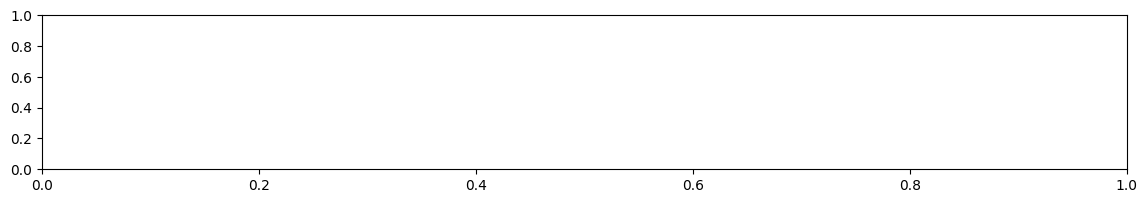

In [8]:
plot_motor_variability(obj)
plot_bg_variability(obj)

### F: Hebbian Learning Weights

In [14]:
obj.hvc_ra_array_all.shape

(60, 1000, 4, 100, 100)

C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_27632\2779146863.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


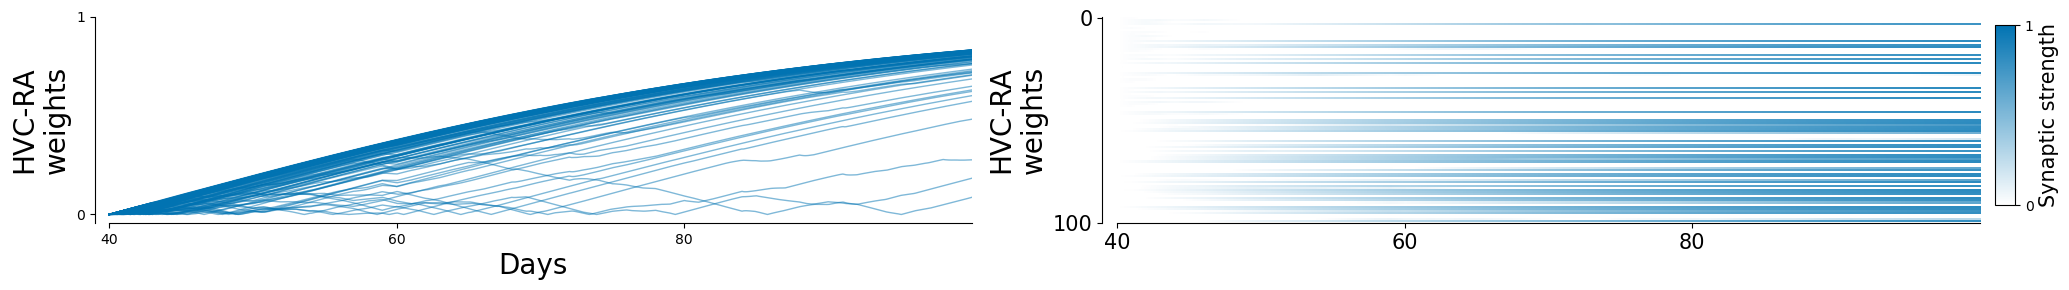

In [25]:
def plot_HL2(obj):
    figure, (ax2, ax1) = plt.subplots(1,2, figsize = (20,3))
    # ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # cm = plt.cm.get_cmap('RdGy_r')
    cm = LinearSegmentedColormap.from_list('grad', ['white', color_cortical])

    plot_array1 = obj.hvc_ra_array_all[:,:,0,0,:].reshape(DAYS*N_DAILY_MOTIFS, obj.ra_size)
    im1 = ax1.imshow((plot_array1[:,:].T), cmap=cm, aspect='auto', interpolation='none', vmin = 0, vmax = 1)

    plot_array2 = obj.hvc_ra_array_all[:, :, 0,0,:].reshape(DAYS*N_DAILY_MOTIFS, obj.ra_size)
    ax2.plot(np.abs(plot_array2[::1, :]), color=color_cortical, alpha=.5, linewidth=1)

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.00, 0.3, 0.01, 0.6]) # type: ignore
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([0, 1])
    
    # figure.subplots_adjust(right=1.2)
    # cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35]) # type:ignore
    # cbar = figure.colorbar(im1, cax=cbar_ax)
    # cbar.set_label('Activity level', fontsize=15)
    # cbar.set_ticks([0, 1])

    # ax1.vlines(BG_INTACT_DAYS * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)   
    # ax2.vlines(BG_INTACT_DAYS * N_DAILY_MOTIFS, 0, 8, color='grey', linestyle='--', lw=1)
    # # ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS], np.arange(40, 40 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 100])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    # ax1.set_ylim(-0.5, 7.5)
    # ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    # ax2.set_ylim(-0.5, 7.5)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 1])
    # ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS], np.arange(40, 40 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('HVC-RA\nweights', fontsize=20)
    # ax2.set_ylabel('RA\nunit', fontsize=20) 
    plt.tight_layout()



# print(obj.hvc_ra_array_all.shape)    
# print(obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.ra_size).shape)
plot_HL2(obj)

C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_27632\2567042441.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


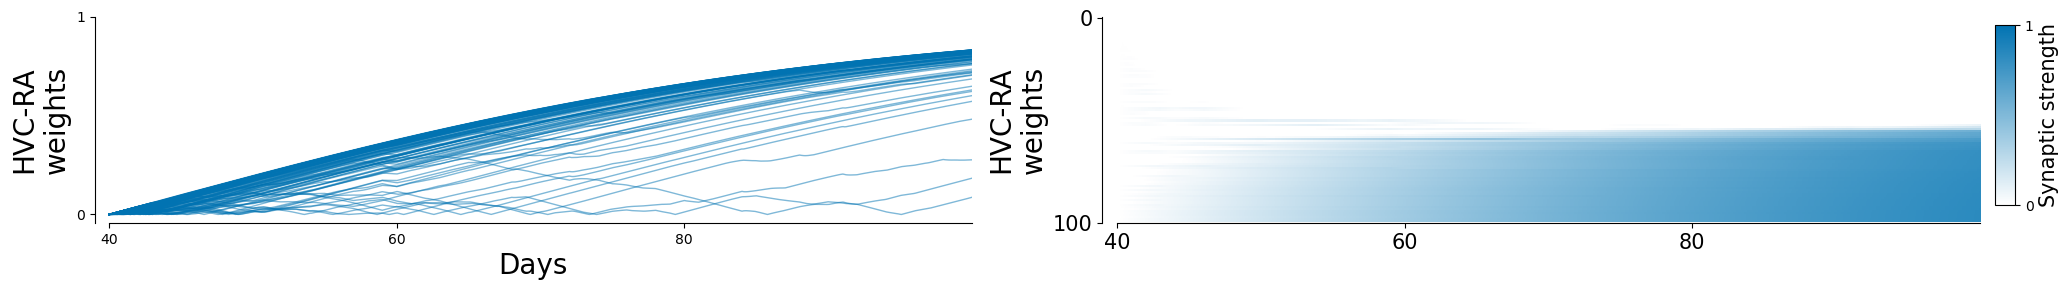

In [26]:
def plot_HL2(obj):
    figure, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 3))
    cm = LinearSegmentedColormap.from_list('grad', ['white', color_cortical])

    # (timepoints, RA neurons)
    plot_array1 = obj.hvc_ra_array_all[:, :, 0, 0, :].reshape(DAYS * N_DAILY_MOTIFS, obj.ra_size)

    # --- compute final sign for each RA neuron ---
    # Take the last day’s motif weights for syllable 0, presynaptic 0, all RA neurons
    last_day_weights = obj.hvc_ra_array_all[-1, :, 0, 0, :]  # shape (1000 motifs, 100 RA)
    final_mean_per_neuron = last_day_weights.mean(axis=0)    # shape (100 RA,)
    signs = np.sign(final_mean_per_neuron)                   # +1 or -1

    sorted_idx = np.argsort(final_mean_per_neuron)  # sorts -1..+1 automatically


    # Apply sorting to RA neurons
    sorted_plot_array1 = plot_array1[:, sorted_idx]  # (timepoints, RA neurons sorted)

    # imshow (neurons on Y axis)
    im1 = ax1.imshow(
        (sorted_plot_array1.T),
        cmap=cm,
        aspect='auto',
        interpolation='none',
        vmin=0,
        vmax=1
    )

    # same sorting for the line plot
    plot_array2 = obj.hvc_ra_array_all[:, :, 0, 0, :].reshape(DAYS * N_DAILY_MOTIFS, obj.ra_size)
    ax2.plot(np.abs(plot_array2[:, sorted_idx]), color=color_cortical, alpha=.5, linewidth=1)

    # colorbar
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.00, 0.3, 0.01, 0.6])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([0, 1])

    # axis cosmetics (same as before)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS], np.arange(40, 40 + DAYS, 20))
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 100])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS * N_DAILY_MOTIFS)
    ax1.spines['bottom'].set_bounds(0, DAYS * N_DAILY_MOTIFS)

    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 1])
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS], np.arange(40, 40 + DAYS, 20))
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS * N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS * N_DAILY_MOTIFS)

    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('HVC-RA\nweights', fontsize=20)

    plt.tight_layout()
    plt.show()
plot_HL2(obj)

### Many simulations? Yes we need it apparently

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import json 
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap

In [2]:
with open("params_3_single.json", "r") as f:
    parameters = json.load(f)

DAYS = parameters['params']['DAYS'] # days for learning

In [3]:
NOS_SIMULATIONS = 25
all_obj_actions = []
all_obj_bg = []
all_obj_ra = []
seeds = np.random.randint(0, 10000, size=NOS_SIMULATIONS)
for sim in range(NOS_SIMULATIONS):
    obj = Environment(seeds[sim], parameters, NN)
    obj.run(parameters, True)
    all_obj_actions.append(obj.actions)
    all_obj_bg.append(obj.bg_all)
    all_obj_ra.append(obj.ra_all)

100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


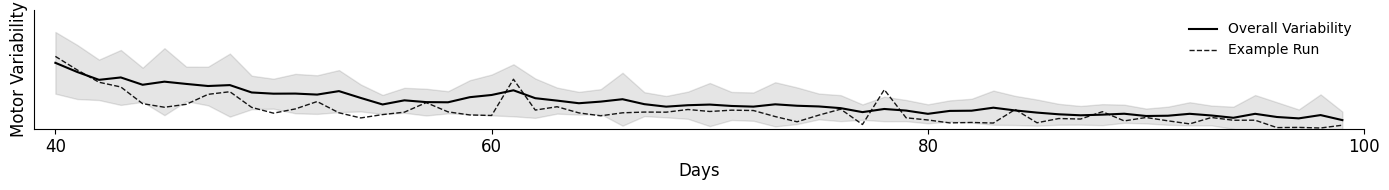

In [13]:
def plot_motor_variability_multiple(all_obj_actions):
    fig, ax = plt.subplots(1, 1, figsize=(14,2))

    days = np.arange(DAYS)
    all_syll_std_x = []
    all_syll_std_y = []
    all_std = []

    for sim in range(len(all_obj_actions)):
        actions = all_obj_actions[sim]
        stds_x = []
        stds_y = []
        for day in days:
            traj_x = actions[day, :, 0, 0]
            traj_y = actions[day, :, 0, 1]
            stds_x.append(np.std(traj_x))
            stds_y.append(np.std(traj_y))

            # ax.plot([min(60, max(0, day+np.random.normal())), min(60, max(0, day+np.random.normal()))], [np.std(traj_x), np.std(traj_y)], color='black', alpha=0.1, lw=0, marker='.', markersize=1)       
        all_std.append((np.array(stds_x) + np.array(stds_y))/2.0)

    all_std = np.array(all_std)

    mean_std = np.mean(all_std, axis=0)
    std_std = np.std(all_std, axis=0)

    # Use visually distinct and colorblind-friendly colors
    ax.plot(days, mean_std, color=color_motor, label='Overall Variability')
    # dashed line
    ax.plot(days, all_std[1], color=color_motor, alpha=0.9, lw=1, linestyle='--', label='Example Run')
    ax.fill_between(days, mean_std - std_std, mean_std + std_std, color=color_motor, alpha=0.1)

    # Plot settings
    ax.set_ylabel("Motor Variability", fontsize=12)
    ax.set_xlabel("Days", fontsize=12)
    ax.set_xticks(range(0, DAYS+1, 20), np.arange(40, DAYS+1 + 40, 20), fontsize=15)

    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(-1, DAYS)
    ax.set_ylim(0, 0.2)
    plt.tight_layout()
    plt.show()
plot_motor_variability_multiple(all_obj_actions)

In [5]:
np.array(all_obj_bg).shape

(25, 60, 1000, 1, 50)

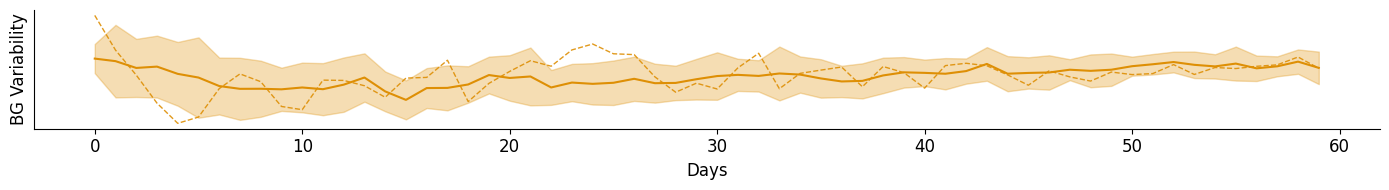

In [14]:
def plot_BG_variability_multiple(all_obj_bg):
    fig, ax = plt.subplots(1, 1, figsize=(14, 2))
    days = np.arange(DAYS)

    stds_all = []

    for sim in range(len(all_obj_bg)):
        bg = all_obj_bg[sim]
        syll = 0
        stds = []
        for day in days:
            bg_overtime = bg[day, :, syll, :]
            stds.append(np.std(bg_overtime, axis=0).mean())
        stds_all.append(stds)

    stds_all = np.array(stds_all)

    mean_stds = np.mean(stds_all, axis=0)
    sem_stds = np.std(stds_all, axis=0) #/ np.sqrt(stds_all.shape[1])

    mean_stds_running = mean_stds
    sem_stds_running = sem_stds

    ax.plot(mean_stds_running, label=f"Syllable {syll}", color=color_bg)
    ax.fill_between(
        days,
        mean_stds_running - sem_stds_running,
        mean_stds_running + sem_stds_running,
        color=color_bg,
        alpha=0.3,
        label="± SEM"
    )
    ax.plot(stds_all[1], color=color_bg, alpha=0.9, lw=1, linestyle='--', label='Example Run')
    # Plot settings
    ax.set_ylabel("BG Variability", fontsize=12)
    ax.set_xlabel("Days", fontsize=12)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_BG_variability_multiple(all_obj_bg)

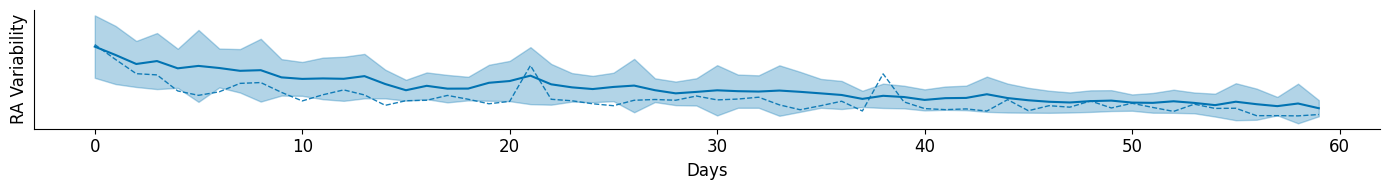

In [15]:
def plot_RA_variability_multiple(all_obj_ra):
    fig, ax = plt.subplots(1, 1, figsize=(14, 2))
    days = np.arange(DAYS)

    stds_all = []

    for sim in range(len(all_obj_ra)):
        ra = all_obj_ra[sim]
        syll = 0
        stds = []
        for day in days:
            ra_overtime = ra[day, :, syll, :]
            stds.append(np.std(ra_overtime, axis=0).mean())
        stds_all.append(stds)

    stds_all = np.array(stds_all)

    mean_stds = np.mean(stds_all, axis=0)
    sem_stds = np.std(stds_all, axis=0) #/ np.sqrt(stds_all.shape[1])

    mean_stds_running = mean_stds
    sem_stds_running = sem_stds

    ax.plot(mean_stds_running, label=f"Syllable {syll}", color=color_cortical)
    ax.fill_between(
        days,
        mean_stds_running - sem_stds_running,
        mean_stds_running + sem_stds_running,
        color=color_cortical,
        alpha=0.3,
        label="± SEM"
    )
    ax.plot(stds_all[1], color=color_cortical, alpha=0.9, lw=1, linestyle='--', label='Example Run')
    # Plot settings
    ax.set_ylabel("RA Variability", fontsize=12)
    ax.set_xlabel("Days", fontsize=12)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_RA_variability_multiple(all_obj_ra)